In [ ]:
import numpy as np    
import matplotlib.pyplot as plt
import pickle
import numpy as np
import yaml
import argparse
import os
#import h5py as h5
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from models.ResNet import Res12_Quadratic, Res18_Quadratic, Res34_Quadratic
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torchvision.transforms.functional as TF
import random
# from diffusers.models import AutoencoderKL
import math
from tqdm import tqdm
from fastmri_brain_data_builder import DataGenImagesOnly, DataGenImagesDownsampled
import pandas as pd
from functions.sampling import Langevin_E, SS_denoise, Annealed_Langevin_E, Annealed_Langevin_Iterative, Reverse_AIS_sampling,AIS_sampling

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

device

device(type='cuda', index=0)

In [2]:
experiment = 'experiment'

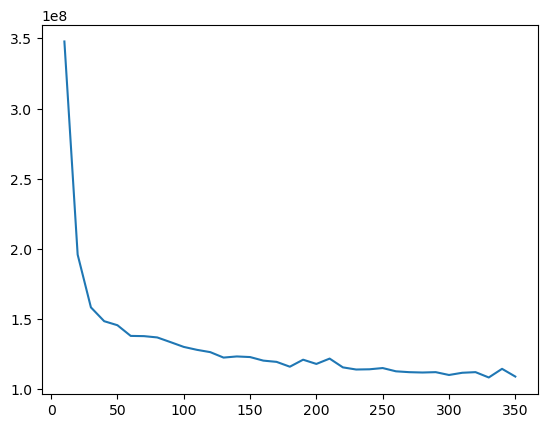

In [ ]:
df = pd.read_csv(f'{experiment}/loss.csv', names=["epoch", "train_loss"])
plt.plot(df['epoch'], df['train_loss'], label='Train loss')

# for i in np.arange(0, 1401, 200):
#     loss = df.loc[df['epoch'] == i, 'train_loss'].values[0]
#     plt.plot(i, loss, marker='o', linestyle='none', color='red')

In [3]:
def convert_to_complex(two_channel_data):
    real_part = two_channel_data[0, :, :]
    imag_part = two_channel_data[1, :, :]

    complex_data = real_part + 1j * imag_part
    return complex_data

In [6]:
def Annealed_Langevin_Iterative(netE, init_x, sigma, T_vect, Sample_every, checkpoints=[0.2, 0.4, 0.6, 0.8, 1.0]):
    """
    Modified Annealed Langevin Sampling that captures intermediate results.
    
    Parameters:
    - netE: the energy model.
    - init_x: initial noisy input.
    - sigma: step size for Langevin dynamics.
    - T_vect: temperature schedule.
    - Sample_every: interval at which samples are saved.
    - checkpoints: list of progress percentages (as fractions of the total steps) where snapshots are saved.
    
    Returns:
    - x_snapshots: list of sampled `x` at specified percentages.
    - E_mtx: matrix of energy values over time.
    """
    
    sigma2 = sigma ** 2
    T_vect = np.sqrt(T_vect)
    K = T_vect.shape[0]  # Total number of Langevin steps
    
    # Determine the iteration steps at which to capture snapshots
    capture_steps = [int(K * checkpoint) if checkpoint < 1.0 else K - 1 for checkpoint in checkpoints]
    
    netE.eval()
    
    E_list = []
    x_snapshots = []  # This will hold the snapshots of x
    x = init_x
    
    for i in range(K):
        x.requires_grad_()
        E_values = netE(x)
        E_list.append(E_values.detach())  # Collect energy values
        E = E_values.sum()
        E.backward()
    
        # Langevin update step
        x = x.detach() - 0.5 * sigma2 * x.grad + T_vect[i] * sigma * torch.randn_like(x)
    
        # Save snapshot if the current iteration matches a capture step
        if i in capture_steps:
            x_snapshots.append(x.detach().cpu())
            print(f'Captured snapshot at Langevin step {i+1}/{K}')
    
    netE.train()
    E_mtx = torch.stack(E_list, 1)
    
    # Return the list of captured snapshots and the energy matrix
    return x_snapshots, E_mtx.cpu().numpy()

In [7]:
netE = Res18_Quadratic(2, 128, 320, normalize=False, AF=nn.ELU())
# netE.load_state_dict(torch.load('experiment5/models/netE_300.pt', map_location=device))
netE.load_state_dict(torch.load('experiment/models/netE_1000.pt', map_location=device))
netE = netE.to(device)

/tmp/ipykernel_60049/2481229077.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netE.load_state_dict(torch.load('experiment/models/netE_1000.pt', map_location=device))


In [8]:
sample_batch_size = 1
annealing_schedule = 'exp'
sample_step_size = 0.11

Nsampling = 2_000
Tmax, Tmin = 36, 1
flat_start_steps, flat_end_steps = 500, 200
init_noise_mean = 0
init_noise_std = 5
final_sigma = 0.05

3 / np.sqrt(Tmax) # for optimal step size assuming np.sqrt(Tmax) * sigma = 3

0.5

In [9]:
if annealing_schedule =='exp':
    # exponential schedule with flat region in the beginning and end
    T = Tmax*np.exp(-np.linspace(0,Nsampling-1,Nsampling)*(np.log(Tmax/Tmin)/Nsampling))
    T = np.concatenate((Tmax*np.ones((flat_start_steps,)),T),axis=0)
    T = np.concatenate((T,Tmin*np.linspace(1,0,flat_end_steps)),axis=0)

elif annealing_schedule == 'lin':
    # linear schedule with flat region in the beginning and end
    T = np.linspace(Tmax,Tmin,Nsampling)
    T = np.concatenate((Tmax*np.ones((flat_start_steps,)),T),axis=0)
    T = np.concatenate((T,Tmin*np.linspace(1,0,flat_end_steps)),axis=0)

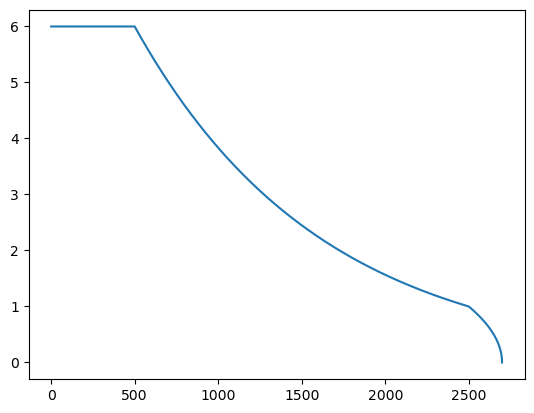

In [10]:
plt.plot(np.sqrt(T))

In [11]:
sample_x = torch.zeros((sample_batch_size, 2, 320, 320))
initial_x = init_noise_mean + init_noise_std * torch.randn_like(sample_x).to(device)

In [12]:
checkpoints = np.linspace(0, 1, 20)
x_snapshots, E_trace = Annealed_Langevin_Iterative(netE, initial_x, sample_step_size, T, 100, checkpoints)

/home/wvy8je/.local/lib/python3.11/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Captured snapshot at Langevin step 1/2700
Captured snapshot at Langevin step 143/2700
Captured snapshot at Langevin step 285/2700
Captured snapshot at Langevin step 427/2700
Captured snapshot at Langevin step 569/2700
Captured snapshot at Langevin step 711/2700
Captured snapshot at Langevin step 853/2700
Captured snapshot at Langevin step 995/2700
Captured snapshot at Langevin step 1137/2700
Captured snapshot at Langevin step 1279/2700
Captured snapshot at Langevin step 1422/2700
Captured snapshot at Langevin step 1564/2700
Captured snapshot at Langevin step 1706/2700
Captured snapshot at Langevin step 1848/2700
Captured snapshot at Langevin step 1990/2700
Captured snapshot at Langevin step 2132/2700
Captured snapshot at Langevin step 2274/2700
Captured snapshot at Langevin step 2416/2700
Captured snapshot at Langevin step 2558/2700
Captured snapshot at Langevin step 2700/2700


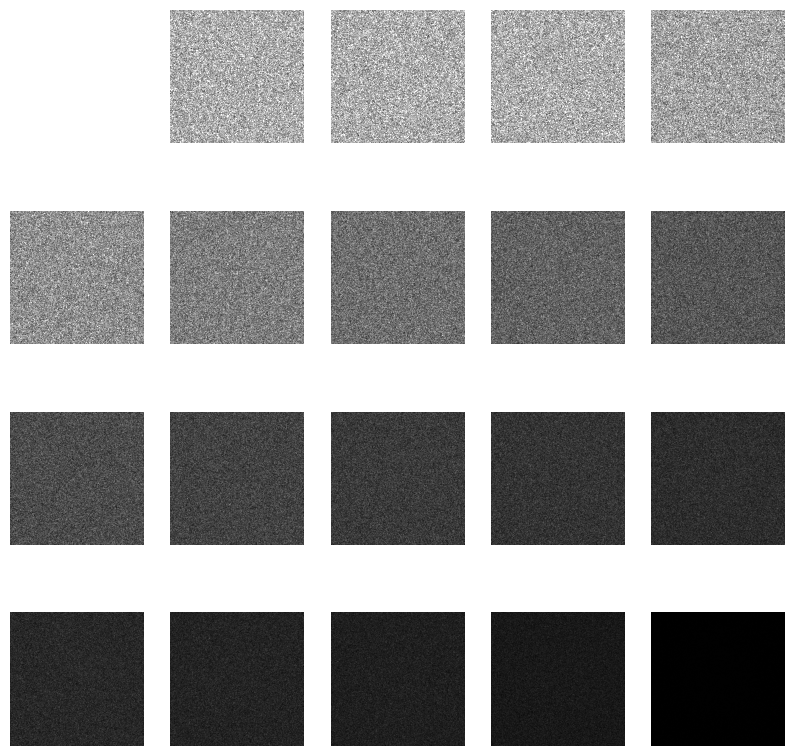

In [14]:
batch_idx = 0

plt.figure(figsize = (10,10))
for i in range(len(x_snapshots)):
    sample = x_snapshots[i][batch_idx].unsqueeze(0)
    sample = SS_denoise(sample.to(device), netE, final_sigma)
    plt.subplot(4, 5, i + 1)
    plt.imshow(convert_to_complex(sample[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)
    plt.axis("off")

In [ ]:
netE(x_snapshots[-1][batch_idx].unsqueeze(0).to(device)), netE(torch.zeros(1, 2, 320, 320).to(device))

(tensor([-16007489.], device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([-16034307.], device='cuda:0', grad_fn=<ViewBackward0>))

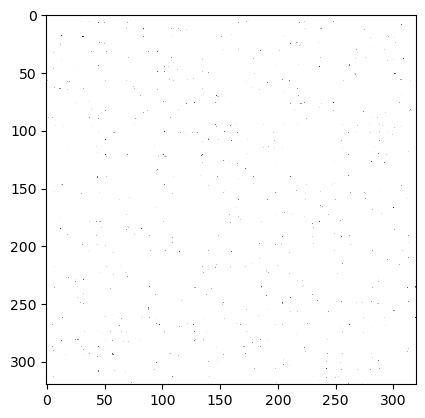

In [ ]:
sample = x_snapshots[0][batch_idx].unsqueeze(0)
sample = SS_denoise(sample.to(device), netE, final_sigma)
plt.imshow(convert_to_complex(sample[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)

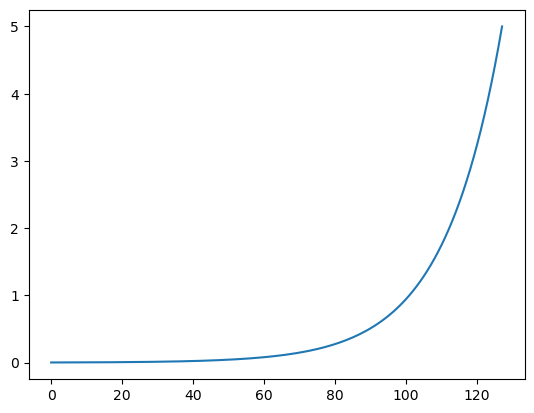

In [ ]:
plt.plot(np.logspace(np.log10(0.002), np.log10(5), num=128))

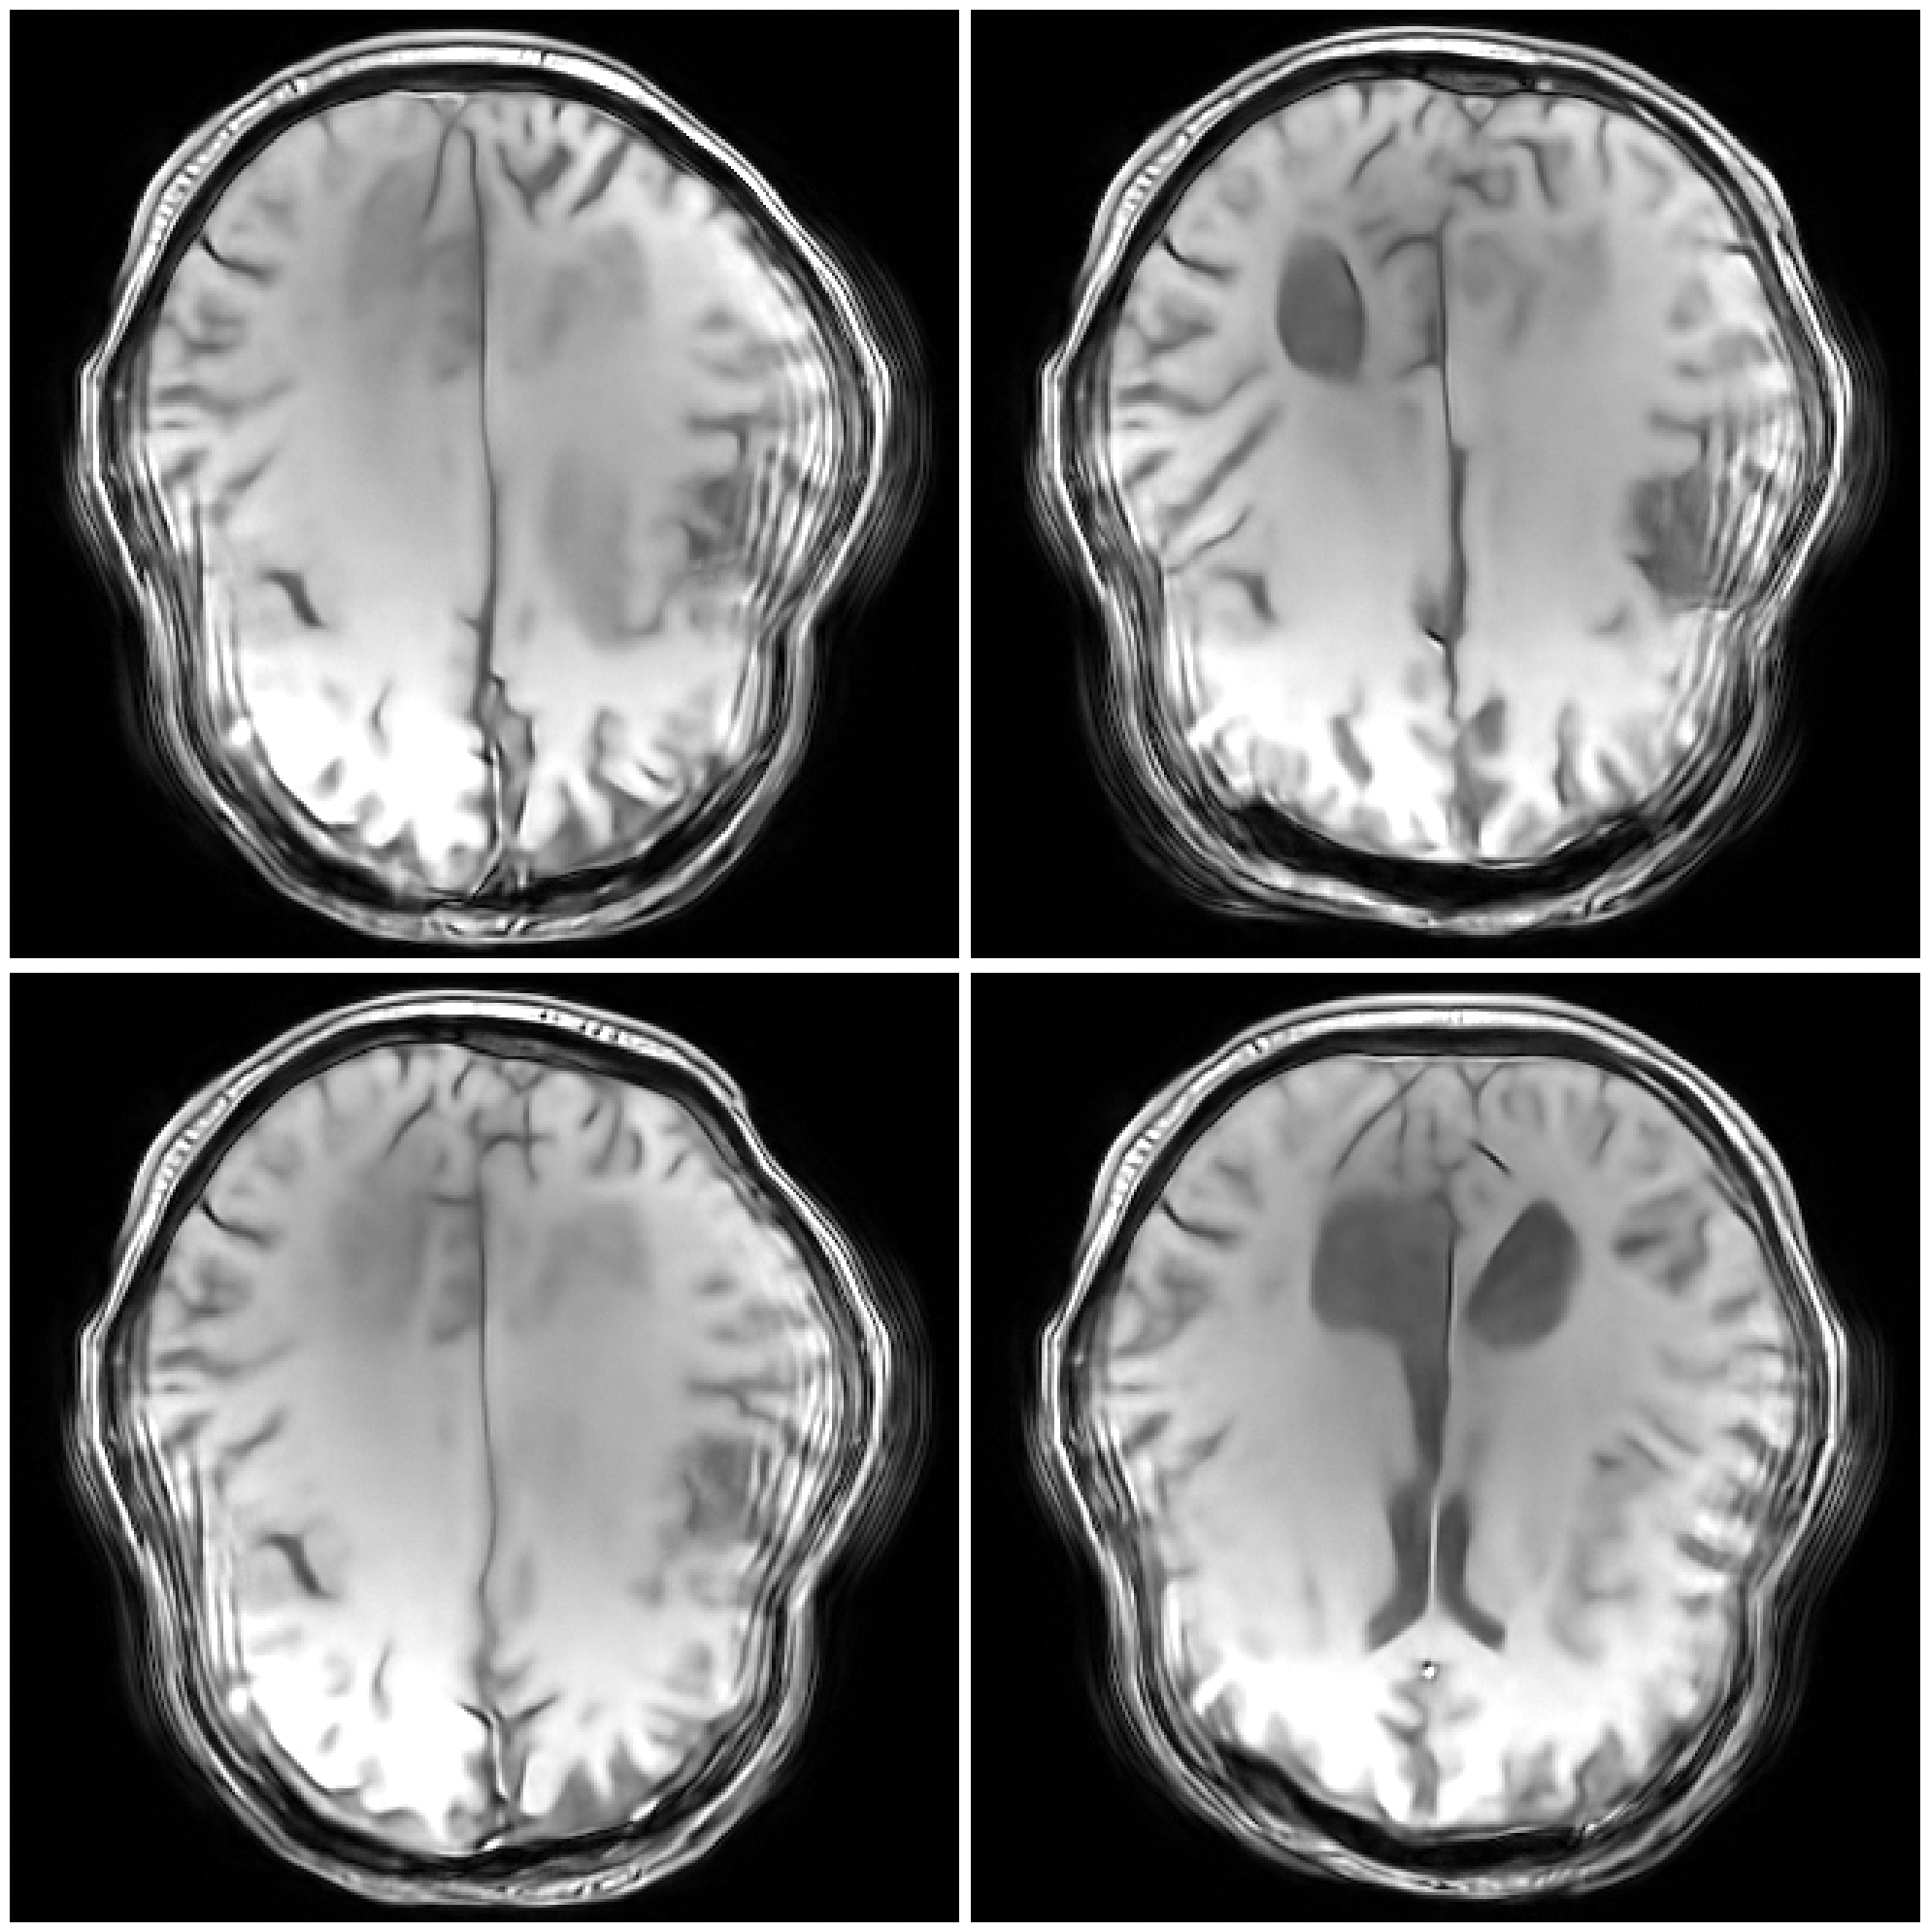

In [ ]:
plt.figure(figsize = (20,20))

for i in range(sample_batch_size):
    sample = x_snapshots[-1][i].unsqueeze(0)
    sample = SS_denoise(sample.to(device), netE, final_sigma)
    plt.subplot(int(np.sqrt(sample_batch_size)), int(np.sqrt(sample_batch_size)), i + 1)
    plt.imshow(convert_to_complex(sample[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)
    plt.axis("off")

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Plot of energy values over sampling from mu=0.5, std=1')

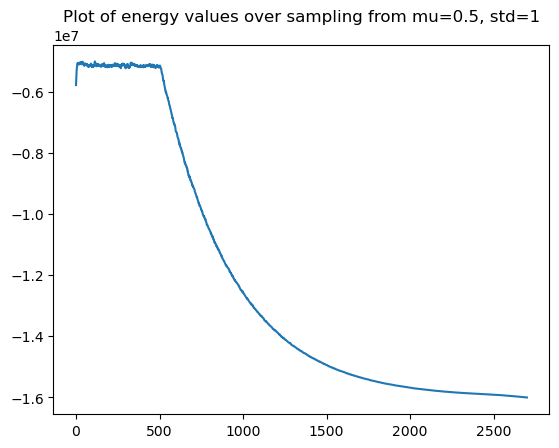

In [ ]:
plt.plot(E_trace[0])
plt.title('Plot of energy values over sampling from mu=0.5, std=1')

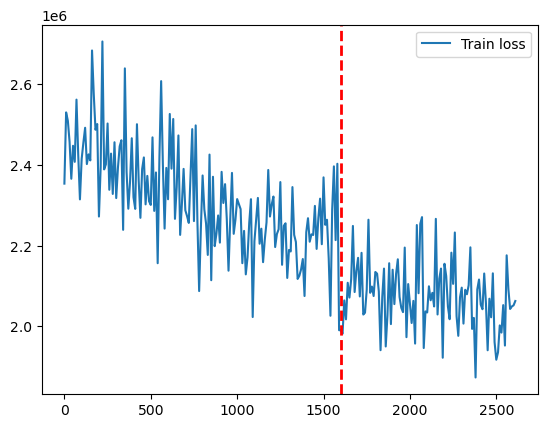

In [ ]:
df = pd.read_csv('experiment/loss.csv', names=["epoch", "train_loss", 'sigma_loss', 'alpha_loss'])
i = df.index[df['epoch'] == 1010].tolist()[0]
plt.plot(list(range(0, i * 10, 10)), df['train_loss'][:i], label='Train loss')
plt.axvline(x=df.index[df['epoch'] == 0].tolist()[0] * 10, color='r', linestyle='--', linewidth=2)
# plt.plot(df['epoch'][i:], df['sigma_loss'][i:], label='Sigma loss')
# plt.plot(df['epoch'][i:], df['alpha_loss'][i:], label='Alpha loss')
plt.legend()

plt.show()

In [ ]:
start = x_snapshots[0][0]
end = x_snapshots[-1][0]

In [ ]:
start[0].mean(), start[0].std(), start[1].mean(), start[1].std(), end[0].mean(), end[0].std(), end[1].mean(), end[1].std()

(tensor(0.5025),
 tensor(0.9989),
 tensor(0.4975),
 tensor(0.9998),
 tensor(0.4543),
 tensor(0.2565),
 tensor(0.5817),
 tensor(0.3209))

(array([9.7000e+01, 1.9939e+04, 9.4410e+03, 6.2916e+04, 9.8940e+03,
        6.6000e+01, 2.3000e+01, 1.7000e+01, 5.0000e+00, 2.0000e+00]),
 array([-0.54428792, -0.18686779,  0.17055234,  0.52797246,  0.88539261,
         1.24281275,  1.60023284,  1.95765305,  2.31507325,  2.67249322,
         3.02991343]),
 <BarContainer object of 10 artists>)

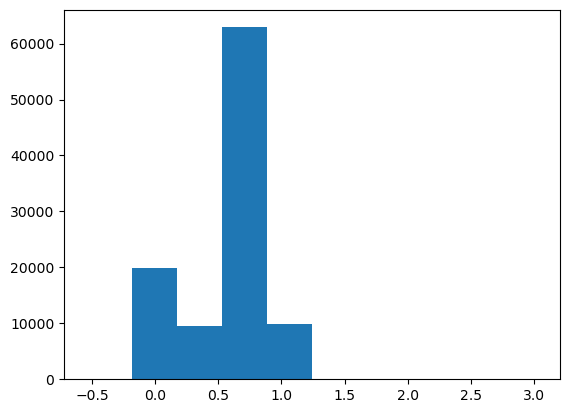

In [ ]:
plt.hist(end[1].flatten())

In [15]:
def preload(path, start_sub = 0, num_sub_per_type = 2, acc = 4.0, num_sl = 10, Cartesian = False, \
            contrast_type = 3):
    #acc: acceleration 
    #num_sl: # of slices per subject
    #Cartesian = True(for Cartesian sampling),Cartesian = False(for Poisson sampling)
    #constrast_type: 0: FLAIR, 1:T1Post, 2:T1, 3:T2
    
    subdirs = sorted(os.listdir(path))
    train_ksp, train_csm, labels = None, None, None
    subdir = subdirs[contrast_type]
    fnames = [filename for filename in sorted(os.listdir(path+subdir)) if filename.endswith('.pickle')]
    print(subdir, '- loading', num_sub_per_type, 'of', len(fnames), 'subjects')
        
    subpath = os.path.join(path, subdir)
    train_fnames = fnames[start_sub:start_sub+num_sub_per_type]
        
    for j, train_fname in enumerate(train_fnames):
        with open(os.path.join(subpath, train_fname), 'rb') as f:
            ksp, csm = pickle.load(f)
            ksp, csm = ksp[:num_sl], csm[:num_sl]
            if j==0:
                train_ksp = torch.tensor(ksp)
                train_csm = torch.tensor(csm)
                labels = torch.ones(ksp.shape[0],)*contrast_type
            else:
                train_ksp = torch.cat((train_ksp, torch.tensor(ksp)))
                train_csm = torch.cat((train_csm, torch.tensor(csm)))
                labels = torch.cat((labels, torch.ones(ksp.shape[0],)*contrast_type))
            print('ksp:', ksp.shape, '\tcsm:', csm.shape)
        
    # print('ksp:', train_ksp.shape, '\ncsm:', train_csm.shape, '\nlabels:', labels.shape,)
    
    if acc == 0:
        mask = torch.ones_like(train_ksp)
    elif acc != None:
        if acc==4 and Cartesian==True:
            mask_filename ='acc4_c.npy'
            print("Acceleration = 4 and Cartesian sampling")
        if acc==2 and Cartesian==True:
            mask_filename ='acc2_c.npy'
            print("Acceleration = 2 and 1D sampling")
        elif acc==4 and Cartesian==False:
            mask_filename ='poisson_mask_2d_acc4.0_320by320.npy'
            print("Acceleration = 4 and Poisson sampling")
        if acc==6:
            mask_filename ='acc_6_t.npy'
            print("Acceleration = 6 and Poisson sampling")
        # mask = np.load(mask_filename).astype(np.complex64)  
        # mask = torch.tensor(np.tile(mask, [train_ksp.shape[0],train_ksp.shape[1],1,1]))
        mask = None
    else:
        mask = None
    
    labels_key = dict(enumerate([subdir.split('_')[0] for subdir in subdirs]))
    print(f"Loaded dataset of {train_ksp.shape[0]} slices\n")
    
    return train_ksp, train_csm, mask, labels.long(), labels_key



def preprocess(ksp, csm, mask):    
    coil_imgs = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(ksp, dim=[-1,-2]),dim=[-1,-2],norm="ortho"), dim=[-1,-2])
    org = torch.sum(coil_imgs*torch.conj(csm),1,True)
    us_ksp = ksp #* mask
    
    return org, us_ksp.type(torch.complex64), csm.type(torch.complex64), mask

import pickle
import numpy as np
import yaml
import argparse
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat



class DataGenBrain(Dataset):
    def __init__(self,  start_sub=0, num_sub=2, device=None, acc=4.0, mask_type=False, data_path='/sfs/ceph/standard/CBIG-Standard-ECE/aniket/FastMRI brain data/',contrast=3):
        self.path = data_path
        self.start_sub = start_sub
        self.num_sub = num_sub
        self.device = device
        self.acc = acc
        self.type=mask_type
        self.contrast = contrast
        self.ksp, self.csm, self.msk, self.labels, self.labels_key = preload(self.path, \
                                                                             self.start_sub, \
                                                                             self.num_sub, \
                                                                             acc = self.acc, \
                                                                             num_sl = 10, \
                                                                             Cartesian = self.type, \
                                                                             contrast_type = self.contrast)
        self.org, self.us_ksp, self.csm, self.msk = preprocess(self.ksp, self.csm, self.msk)


        
    def __len__(self):
        return self.org.size()[0]
   
        
    def __getitem__(self, i):
        return self.org[i:i+1].to(self.device)
        # return self.org[i:i+1].to(self.device), self.us_ksp[i:i+1].to(self.device), \
        #        self.csm[i:i+1].to(self.device), self.msk[i:i+1].to(self.device), \
        #        self.labels[i:i+1].to(self.device)
    
    def get_noisy(self, i, noise_eps=0.):
        us_ksp = self.us_ksp[i:i+1] 
        msk = self.msk[i:i+1]
        scale = 1/torch.sqrt(torch.tensor(2.))
        us_ksp = us_ksp + msk*(torch.randn(us_ksp.shape)+1j*torch.randn(us_ksp.shape))*scale*noise_eps
        
        return self.org[i:i+1].to(self.device)
        # return self.org[i:i+1].to(self.device), us_ksp.to(self.device), \
        #        self.csm[i:i+1].to(self.device), msk.to(self.device), \
        #        self.labels[i:i+1].to(self.device)

acc=4
rd=DataGenBrain(start_sub=1, num_sub=10, device=device, acc=acc,contrast=2)

T1_big_pickle - loading 10 of 104 subjects
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
ksp: (10, 12, 320, 320) 	csm: (10, 12, 320, 320)
Acceleration = 4 and Poisson sampling
Loaded dataset of 100 slices



In [16]:
netE = Res18_Quadratic(2, 128, 320, normalize=False, AF=nn.ELU())
netE.load_state_dict(torch.load('experiment5/models/netE_300.pt', map_location=device))
netE = netE.to(device)

/tmp/ipykernel_60049/3124179310.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netE.load_state_dict(torch.load('experiment5/models/netE_300.pt', map_location=device))


In [ ]:
desired_batch_size = 128
batch_size = 32
parts = desired_batch_size // batch_size

# sigmas_np = np.logspace(np.log10(0.002), np.log10(5), num=desired_batch_size)
# sigmas_np = np.linspace(0.002, 5, desired_batch_size)
sigmas_np = np.linspace(0.05, 3, desired_batch_size)
sigmas = torch.Tensor(sigmas_np).view((desired_batch_size,1,1,1)).to(device)

# alphas_np = np.linspace(0.0001, 1 - 0.0001, desired_batch_size)
# alphas = torch.Tensor(alphas_np).view((desired_batch_size,1,1,1)).to(device)

sigma0 = 0.1
sigma02 = sigma0**2
lambda2 = 1e-5 # coefficient multiplied by pair loss

def augment_batch(batch, flip_type):
    # angle = float(np.random.choice([0, 90, 180, 270]))
    # org_rotated = torch.stack([TF.rotate(img, angle) for img in batch])
    # return org_rotated

    if flip_type == "horizontal":
        return TF.hflip(batch)
    else:
        return batch

In [ ]:
### LOSS SIMULATION ###

avg_loss = torch.zeros(1, dtype=torch.double)
# avg_sigma_loss = torch.zeros(1, dtype=torch.double)
# avg_alpha_loss = torch.zeros(1, dtype=torch.double)
avg_loss_per_sigma = torch.zeros(len(sigmas_np))
num_items_per_sigma = torch.zeros(len(sigmas_np))
num_items = 0

epochs = 5

for epoch in range(epochs):

    transform = random.choice(["horizontal", "none"])
    data_loader = DataLoader(dataset=rd, batch_size=batch_size, shuffle=True)

    for i, org in enumerate(data_loader):

        org = torch.squeeze(org, 1)
        org = org.to(device)
        org = torch.cat((org.real, org.imag), 1).float()
        org = org.to(device)

        org = augment_batch(org, transform)
        i %= parts
        
        if(org.shape[0]==batch_size): #eliminate small batches, which is a problem for linspace
            sigmas_part = sigmas[i*batch_size:(i+1)*batch_size]
            noise = sigmas_part * torch.randn_like(org)
            
            org_noisy = org + noise
            org_noisy = org_noisy.requires_grad_()
            E = netE(org_noisy).sum()
            
            grad_x = torch.autograd.grad(E, org_noisy, create_graph=False)[0]
            # org_noisy = org_noisy.detach()
            org_noisy.detach()

            main_loss = (((org - org_noisy)/sigmas_part/sigma02+grad_x/sigmas_part)**2).cpu()
            batch_mean = main_loss.mean(dim=(1, 2, 3))
            avg_loss_per_sigma[i*batch_size:(i+1)*batch_size] += batch_mean
            num_items_per_sigma[i*batch_size:(i+1)*batch_size] += 1
            
            sigma_loss = (main_loss/batch_size).sum() / float(parts) #+ lambda2 * (netE(org).sum() - netE(alpha * org).sum())
            # sigma_loss.backward()
            
            # alphas_part = alphas[i::parts]
            
            # org_alpha = org * (-alphas_part) # amount of resolution we're removing from org
            # org_scaled = org + org_alpha # scaled img (less bright)
            # org_scaled = org_scaled.requires_grad_()
            # E = netE(org_scaled).sum()

            # grad_x = torch.autograd.grad(E, org_scaled, create_graph=True)[0]
            # org_alpha = org_alpha.detach()

            # alpha_loss = lambda2 * (((grad_x / (1 - alphas_part) - org_alpha / (1 - alphas_part) / sigma02)**2) / batch_size).sum() / float(parts) # essentially, we're trying to get the negative gradient to match the direction the img must go to get to the right scale
            
            # alpha_loss.backward()

            if i == parts - 1:
                transform = random.choice(["horizontal", "none"])

            with torch.no_grad():
                avg_loss += sigma_loss.item() * batch_size
                # avg_loss += (sigma_loss + alpha_loss).item() * batch_size
                # avg_sigma_loss += sigma_loss.item() * batch_size
                # avg_alpha_loss += alpha_loss.item() * batch_size    
                num_items += batch_size

    epoch_loss = (avg_loss/num_items).item()
    # epoch_sigma_loss = (avg_sigma_loss/num_items).item()
    # epoch_alpha_loss = (avg_alpha_loss/num_items).item()
    # print(epoch_loss, epoch_sigma_loss, epoch_alpha_loss)
    print(epoch_loss)

2274815.94140625
2115315.05078125
2127911.8665364585
2081791.2543945312
2086127.36875


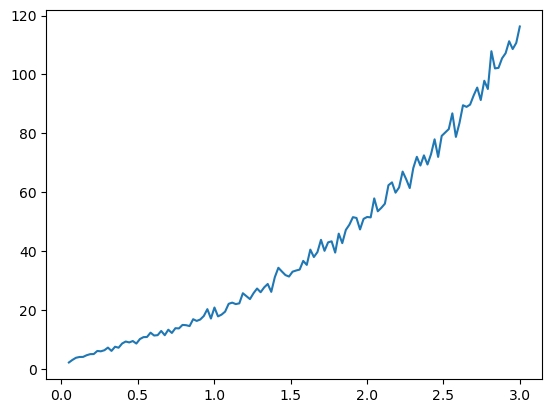

In [ ]:
plt.plot(sigmas_np, (avg_loss_per_sigma / num_items_per_sigma).detach().numpy() * (sigmas_np ** 2))

In [ ]:
e_values = []
data_loader = DataLoader(dataset=rd, batch_size=1, shuffle=True)
for org in tqdm(data_loader):
    print(org.shape)
    org = torch.squeeze(org, 1)
    org = org.to(device)
    org = torch.cat((org.real, org.imag), 1).float()
    org = org.to(device)
    print(org.shape)
    with torch.no_grad():
        e = netE(org).sum().cpu().item()
    e_values.append(e)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 1, 1, 320, 320])
torch.Size([1, 2, 320, 320])


NameError: name 'netE' is not defined

(array([ 3., 10., 17., 12., 20., 14.,  8.,  6.,  6.,  4.]),
 array([-14410193. , -14410125.4, -14410057.8, -14409990.2, -14409922.6,
        -14409855. , -14409787.4, -14409719.8, -14409652.2, -14409584.6,
        -14409517. ]),
 <BarContainer object of 10 artists>)

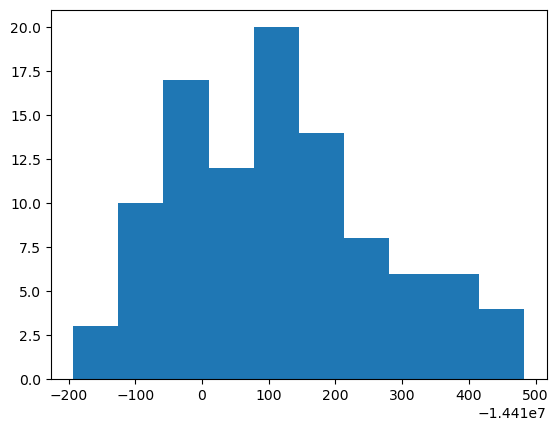

In [ ]:
plt.hist(e_values)

In [ ]:
netE = Res18_Quadratic(2, 128, 320, normalize=False, AF=nn.ELU())
netE.load_state_dict(torch.load('experiment3/models/netE_800.pt', map_location=device))
netE = netE.to(device)

/tmp/ipykernel_320976/739661796.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netE.load_state_dict(torch.load('experiment3/models/netE_800.pt', map_location=device))


FileNotFoundError: [Errno 2] No such file or directory: 'experiment3/models/netE_800.pt'

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


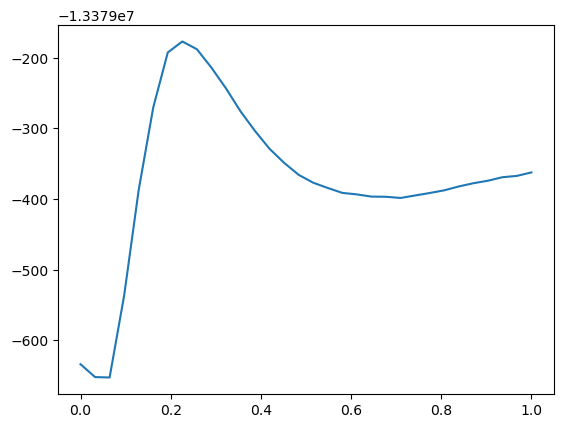

In [17]:
alphas = np.linspace(0, 1, 32)
res = [0] * 32

data_loader = DataLoader(dataset=rd, batch_size=1, shuffle=True)
for org in tqdm(data_loader):
    org = torch.squeeze(org, 1)
    org = org.to(device)
    org = torch.cat((org.real, org.imag), 1).float()
    org = org.to(device)
    
    for i, alpha in enumerate(alphas):
        e = netE(org * alpha).sum().cpu().item()
        res[i] += e

plt.plot(alphas, np.array(res) / len(rd))

In [ ]:
netE(torch.zeros(1, 2, 320, 320).to(device)), min(e_values)

(tensor([-19028816.], device='cuda:0', grad_fn=<ViewBackward0>), -19027482.0)

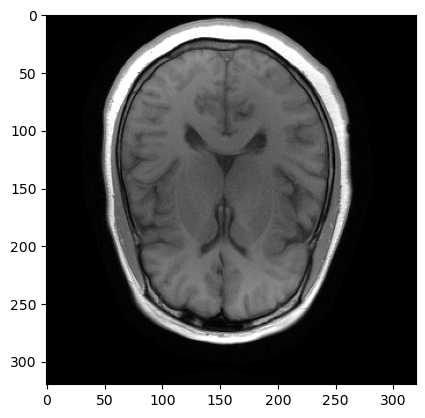

In [ ]:
org = rd[0]
org = torch.cat((org.real, org.imag), 1).float()
plt.imshow(convert_to_complex(org[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)

tensor([-21595584.], device='cuda:0', grad_fn=<ViewBackward0>)

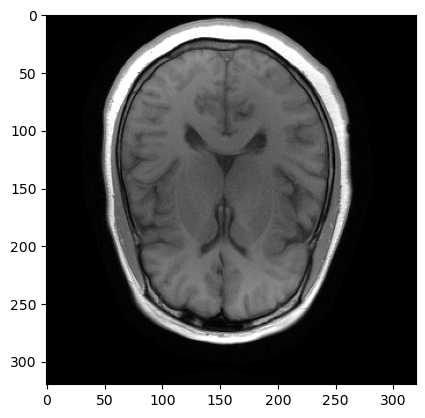

In [ ]:
org = rd[0]
org = torch.cat((org.real, org.imag), 1).float().to(device)

plt.imshow(convert_to_complex(org[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)
netE(org)

tensor([-21599900.], device='cuda:0', grad_fn=<ViewBackward0>)

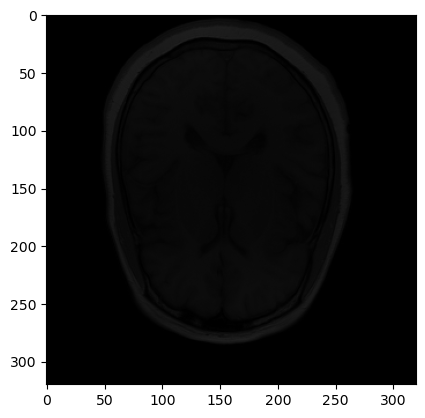

In [ ]:
alpha = 0.1
plt.imshow(convert_to_complex(alpha * org[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)

netE(alpha * org)

In [ ]:
dists_real = []
dists_imag = []
for i in tqdm(range(len(rd))):
    org = rd[i]
    less_real = (org.real < 0).float().cpu().mean()
    dists_real.append((1 - less_real) - less_real)
    less_imag = (org.imag < 0).float().cpu().mean()
    dists_imag.append((1 - less_imag) - less_imag)

100%|██████████| 1030/1030 [00:01<00:00, 940.05it/s]


Text(0.5, 0, 'Percentage of values < 0 compared to values > 0')

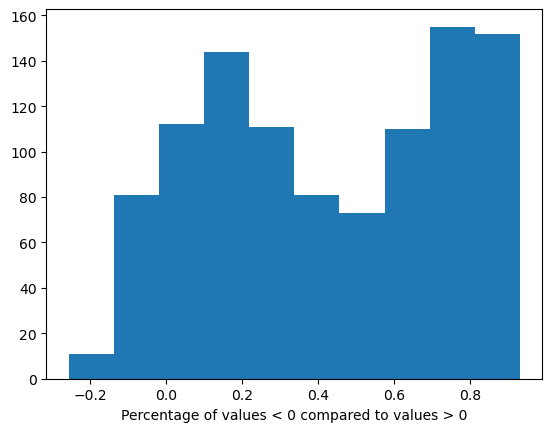

In [ ]:
plt.hist(dists_imag)
plt.xlabel('Percentage of values < 0 compared to values > 0')

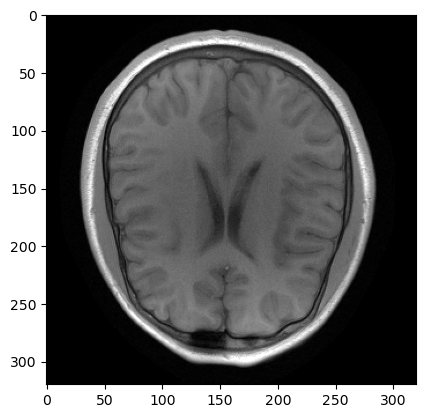

In [ ]:
i = np.argmin(dists_imag)

org = rd[i]
org = torch.cat((org.real, org.imag), 1).float()
plt.imshow(convert_to_complex(org[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)

In [ ]:
less_real = (org.real < 0).float().cpu().mean()

(1 - less_real) - less_real, np.min(dists_real)

(tensor(0.0806), -0.17437506)

(array([   157.,    985.,  20253.,  30284.,  21167., 110946.,  17900.,
          2268.,    717.,    123.]),
 array([-1.30503249, -1.05921245, -0.81339228, -0.56757224, -0.32175213,
        -0.07593203,  0.16988806,  0.41570815,  0.66152823,  0.90734833,
         1.15316844]),
 <BarContainer object of 10 artists>)

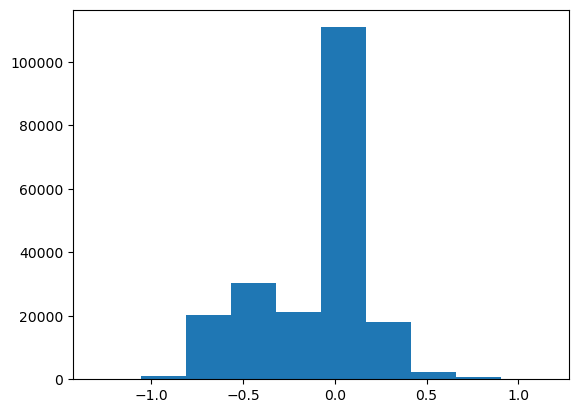

In [ ]:
plt.hist(org.real.flatten().cpu())

In [ ]:
e_vals[0]

-17701764.0

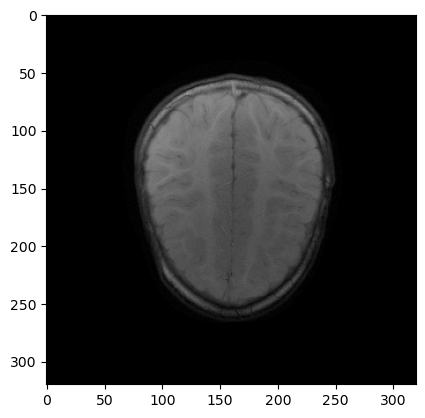

In [ ]:
i = np.argmin(e_vals)

org = rd[i]
org_2_channel = torch.cat((org.real, org.imag), 1).float().abs()
plt.imshow(convert_to_complex(org_2_channel[0]).abs().detach().cpu(), plt.cm.gray, vmin=0, vmax=1)

(array([2.2000e+01, 7.2400e+02, 2.2540e+03, 5.8840e+03, 9.4740e+03,
        8.1321e+04, 1.5610e+03, 8.8900e+02, 2.1600e+02, 5.5000e+01]),
 array([-0.55423552, -0.44796899, -0.34170246, -0.23543593, -0.1291694 ,
        -0.02290288,  0.08336365,  0.18963018,  0.29589671,  0.40216324,
         0.50842977]),
 <BarContainer object of 10 artists>)

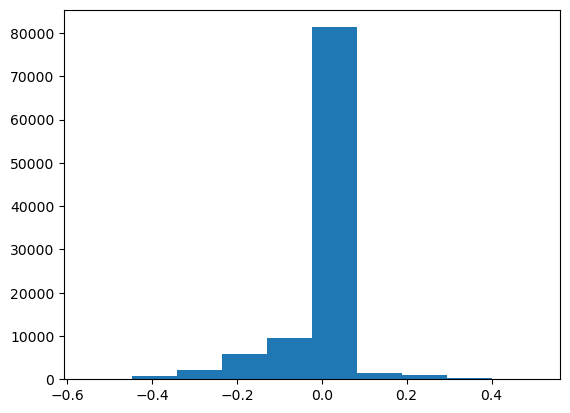

In [ ]:
plt.hist(org_2_channel[0][1].cpu().flatten())

In [ ]:
dataloader = DataLoader(rd, batch_size=1, shuffle=False)

real_mean = []
real_std = []
imag_mean = []
imag_std = []
for img in tqdm(dataloader):
    img = img.cpu().numpy()
    real_mean.append(img.real.mean())
    real_std.append(img.real.std())
    imag_mean.append(img.imag.mean())
    imag_std.append(img.imag.std())

100%|██████████| 1030/1030 [00:00<00:00, 1471.63it/s]


(array([ 13.,  48., 169., 329., 227., 128.,  73.,  21.,  16.,   6.]),
 array([0.05405075, 0.08517882, 0.1163069 , 0.14743497, 0.17856304,
        0.20969112, 0.24081919, 0.27194726, 0.30307534, 0.33420341,
        0.36533148]),
 <BarContainer object of 10 artists>)

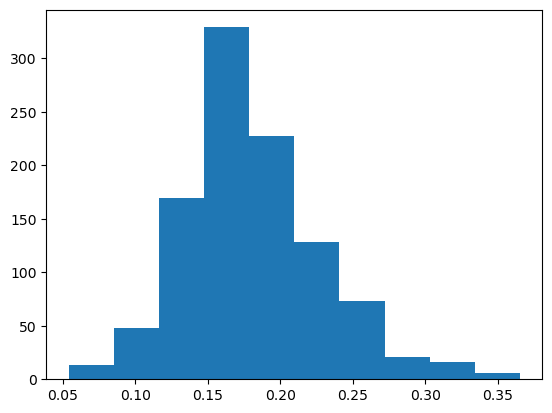

In [ ]:
plt.hist(imag_std)

In [ ]:
np.mean(imag_std)

0.181191840482475

In [ ]:
rd[0].cpu().imag.std()

tensor(0.2232, dtype=torch.float64)